# DEMO — Seismic acquisition

Things you might need to install:

    conda install pyproj
    conda install geopandas
    conda install fiona
    conda install shapely

The idea is to replicate what we've done so far but with 3 enhancements:

- With a `Survey` object to hold the various features of a survey.
- With more `geopandas` stuff, and less fussing with (x,y)'s directly.
- Making bins and assigning midpoints to them.

We'll start with the usual prelims...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
import geopandas as gpd
import pandas as pd
from fiona.crs import from_epsg

%matplotlib inline

## Survey object

I've tried to keep this fairly simple. Some new methods we could write into here:

- Calculate midpoints
- Calculate offsets and azimuths
- Plotting methods
- Calculate bins
- Bin the midpoints

Some enhancements:

- Would having `Source` and `Receiver` objects be advatangeous?
- Add the concept of a patch.
- Add the concept of the dynamic acquisition program itself.
- Add forward modeling.

In [29]:
class Survey:
    """
    A seismic survey.
    """

    def __init__(self, params):
        
        # Assign the variables from the parameter dict.
        for k, v in params.items(): 
            setattr(self, k, v)
          
        # These are just a convenience; we could use the
        # tuples directly, or make objects with attrs.
        self.xmi = self.corner[0]
        self.ymi = self.corner[1]
        
        self.x = self.size[0]
        self.y = self.size[1]
        
        self.SL = self.line_spacing[0]
        self.RL = self.line_spacing[1]
        
        self.si = self.point_spacing[0]
        self.ri = self.point_spacing[1]
        
        self.shiftx = -self.si/2.
        self.shifty = -self.ri/2.
           
    @property
    def lines(self):
        """
        Returns number of (src, rcvr) lines.
        """
        slines = int(self.x/self.SL) + 1
        rlines = int(self.y/self.RL) + 1
        return slines, rlines

    @property
    def points_per_line(self):
        """
        Returns number of (src, rcvr) points per line.
        """
        spoints = int(self.y/self.si) + 2
        rpoints = int(self.x/self.ri) + 2
        return spoints, rpoints
    
    @property
    def src(self):
        s = [Point(self.xmi+line*self.SL, self.ymi+s*self.si)
             for line in range(self.lines[0])
             for s in range(self.points_per_line[0])
             ]
        S = gpd.GeoSeries(s)
        S.crs = from_epsg(26911)
        return S

    @property
    def rcvr(self):
        r = [Point(self.xmi + r*self.ri + self.shiftx, self.ymi + line*self.RL - self.shifty)
             for line in range(self.lines[1])
             for r in range(self.points_per_line[1])
             ]
        R = gpd.GeoSeries(r)
        R.crs = from_epsg(self.epsg)
        return R
    
    @property
    def layout(self):
        """
        Provide a GeoDataFrame of all points,
        labelled as columns and in hierarchical index.
        """
        # Feels like there might be a better way to do this...
        sgdf = gpd.GeoDataFrame({'geometry': self.src, 'station': 'src'})
        rgdf = gpd.GeoDataFrame({'geometry': self.rcvr, 'station': 'rcvr'})

        # Concatenate with a hierarchical index
        layout = pd.concat([sgdf,rgdf], keys=['sources','receivers'])
        layout.crs = from_epsg(self.epsg)

        return layout

Perhaps s and r should be objects too. I think you might want to have survey.receivers.x for the list of x locations, for example.

## Instantiate and plot

In [30]:
params = {'corner': (5750000,4710000),
          'size': (3000,1800),
          'line_spacing': (600,600),
          'point_spacing': (100,100),
          'epsg': 26911 # http://spatialreference.org/ref/epsg/26911/
          }

survey = Survey(params)

In [31]:
s = survey.src
r = survey.rcvr
r[:10]

0    POINT (5749950 4710050)
1    POINT (5750050 4710050)
2    POINT (5750150 4710050)
3    POINT (5750250 4710050)
4    POINT (5750350 4710050)
5    POINT (5750450 4710050)
6    POINT (5750550 4710050)
7    POINT (5750650 4710050)
8    POINT (5750750 4710050)
9    POINT (5750850 4710050)
dtype: object

In [32]:
layout = survey.layout
layout[:10]

geometry station
sources 0  POINT (5750000 4710000)     src
        1  POINT (5750000 4710100)     src
        2  POINT (5750000 4710200)     src
        3  POINT (5750000 4710300)     src
        4  POINT (5750000 4710400)     src
        5  POINT (5750000 4710500)     src
        6  POINT (5750000 4710600)     src
        7  POINT (5750000 4710700)     src
        8  POINT (5750000 4710800)     src
        9  POINT (5750000 4710900)     src

With a hierarchical index you can do cool things, e.g. show the last five sources:

In [33]:
layout.ix['sources'][-5:]

,geometry,station
115,POINT (5753000 4711500),src
116,POINT (5753000 4711600),src
117,POINT (5753000 4711700),src
118,POINT (5753000 4711800),src
119,POINT (5753000 4711900),src


In [34]:
layout.crs

{'init': 'epsg:26911', 'no_defs': True}

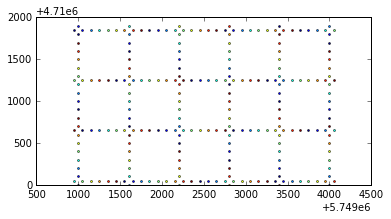

In [35]:
ax = layout.plot()  # Native plot method.

Export GeoDataFrames to GIS shapefile. This native GeoPandas method depends on `fiona`.

In [9]:
# gdf.to_file('src_and_rcvr.shp')

## Midpoint calculations

We need **midpoints**. There is a midpoint between every source-receiver pair. This is the point in the earth we imagine we are 'seeing' when we record a reflection from source *S* at recevier location *R*.

It's not too inelegant to get to the midpoints now that we're using this layout object thing. `normalized=True` just tells `interpolate()` to treat the `0.5` as a fraction of the length of the linestring.

In [36]:
midpoint_list = [LineString([r, s]).interpolate(0.5, normalized=True)
                  for r in layout.ix['receivers'].geometry
                  for s in layout.ix['sources'].geometry
                  ]

As well as knowing the (x,y) of the midpoints, we'd also like to record the **offset**, the distance from each *s* to each live *r* (each *r* in the live patch). This is easy enough to compute:

    Point(x1, y1).distance(Point(x2, y2))
 
Then we can make a list of all the offsets when we count the midpoints into the bins. 

In [37]:
offsets = [r.distance(s)
           for r in layout.ix['receivers'].geometry
           for s in layout.ix['sources'].geometry
           ]

In [38]:
azimuths = [(180.0/np.pi) * np.arctan((r.x - s.x)/(r.y - s.y))
            for r in layout.ix['receivers'].geometry
            for s in layout.ix['sources'].geometry
            ]

We can get the offset in *x* and *y* directions too — we need these for the spider plot.

In [39]:
offsetx = np.array(offsets)*np.cos(np.array(azimuths)*np.pi/180.)
offsety = np.array(offsets)*np.sin(np.array(azimuths)*np.pi/180.)

Make a Geoseries of the midpoints, offsets and azimths:

In [99]:
midpoints = gpd.GeoDataFrame({
                   'geometry' : midpoint_list,
                   'offset' : offsets,
                   'azimuth': azimuths,
                   'offsetx' : offsetx,
                   'offsety' : offsety
                   })
midpoints[:5]

,azimuth,geometry,offset,offsetx,offsety
0,-45.000000,POINT (5749975 4710025),70.710678,50.0,-50.0
1,45.000000,POINT (5749975 4710075),70.710678,50.0,50.0
2,18.434949,POINT (5749975 4710125),158.113883,150.0,50.0
3,11.309932,POINT (5749975 4710175),254.950976,250.0,50.0
4,8.130102,POINT (5749975 4710225),353.553391,350.0,50.0


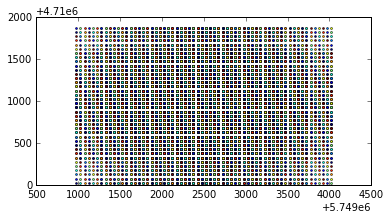

In [100]:
ax = midpoints.plot()

Save to a shapefile if desired. 

In [101]:
#midpt.to_file('CMPs.shp')

## Spider plot

We can use a 'quiver plot'.

We need lists (or arrays) to pass into the [matplotlib quiver plot](http://matplotlib.org/examples/pylab_examples/quiver_demo.html). This takes four main parameters: *x, y, u,* and *v*, where *x, y* will be our coordinates, and *u, v* will be the offset vector for that midpoint.

Let's get *x* and *y* first:

In [102]:
x, y = zip(*[g.xy for g in midpoints.geometry])

...and the offsets which we calculated earlier:

In [103]:
midpoints[:5].offsetx # Easy!

0     50.0
1     50.0
2    150.0
3    250.0
4    350.0
Name: offsetx, dtype: float64

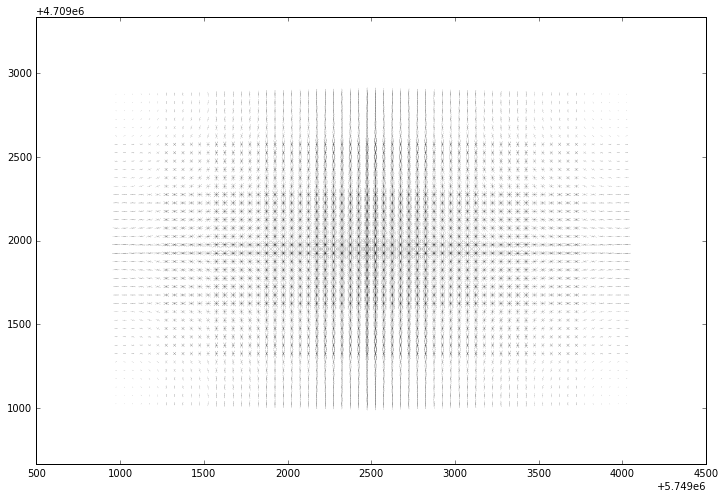

In [104]:
fig = plt.figure(figsize=(12,8))
plt.quiver(x, y, midpoints.offsetx, midpoints.offsety, units='xy', width=0.5, scale=1/0.025, pivot='mid', headlength=0)
plt.axis('equal')
plt.show()

## Bins

The bins are a new geometry, related to but separate from the survey itself, and the midpoints. We will model them as a GeoDataFrame of polygons. The steps are:

1. Compute the bin centre locations with our usual list comprehension trick.
1. Buffer the centres with a square.
1. Gather the buffered polygons into a GeoDataFrame.

In [105]:
# Factor to shift the bins relative to source and receiver points
jig = survey.si / 4.
bin_centres = gpd.GeoSeries([Point(survey.xmi + 0.5*r*survey.ri + jig, survey.ymi + 0.5*s*survey.si + jig)
                             for r in range(2*survey.points_per_line[1] - 3)
                             for s in range(2*survey.points_per_line[0] - 2)
                            ])

# Buffers are diamond shaped so we have to scale and rotate them.
scale_factor = np.sin(np.pi/4.)/2.
bin_polys = bin_centres.buffer(scale_factor*survey.ri, 1).rotate(-45)
bins = gpd.GeoDataFrame(geometry=bin_polys)

bins[:3]

,geometry
0,"POLYGON ((5750050 4710000, 5750000 4710000, 57..."
1,"POLYGON ((5750050.000000001 4710050, 5750000 4..."
2,"POLYGON ((5750050.000000001 4710100, 5749999.9..."


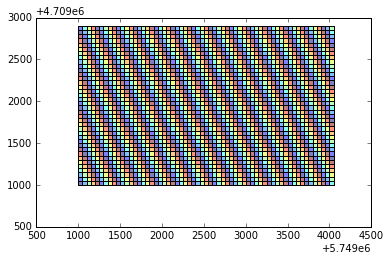

In [106]:
ax = bins.plot()

## Collect midpoints into bins

We need to collect the midpoints into their bins. This is called a 'spatial join'. There are two steps:

1. Created a `joined` dataframe that maps every midpoint into a unique bin. Some midpoints will have the same bin.
1. Count the midpoints in each bin, to get the **fold**, and get the **minimum offset** in each bin. Both of these are predictors of the quality of the seismic we'll end up with.

First, the join.

Thank you to Jake Wasserman and Kelsey Jordahl for this code snippet, and many pointers. This takes a few seconds to run on my iMac, compared to something close to 30 minutes for the old nested loops. 

In [107]:
reindexed = bins.reset_index().rename(columns={'index':'bins_index'})
joined = gpd.tools.sjoin(reindexed, midpoints)

In [108]:
joined[:10]

,bins_index,geometry,index_right,azimuth,offset,offsetx,offsety
0,0,"POLYGON ((5750050 4710000, 5750000 4710000, 57...",120,45.000000,70.710678,50.0,50.0
1,1,"POLYGON ((5750050.000000001 4710050, 5750000 4...",121,-45.000000,70.710678,50.0,-50.0
2,2,"POLYGON ((5750050.000000001 4710100, 5749999.9...",122,-18.434949,158.113883,150.0,-50.0
3,3,"POLYGON ((5750050 4710150, 5750000 4710150, 57...",123,-11.309932,254.950976,250.0,-50.0
4,4,"POLYGON ((5750050 4710200, 5750000 4710200, 57...",124,-8.130102,353.553391,350.0,-50.0
5,5,"POLYGON ((5750050 4710250, 5750000 4710250, 57...",125,-6.340192,452.769257,450.0,-50.0
6,6,"POLYGON ((5750050 4710300, 5750000 4710300, 57...",126,-5.194429,552.268051,550.0,-50.0
6,6,"POLYGON ((5750050 4710300, 5750000 4710300, 57...",3960,4.398705,651.920241,650.0,50.0
7,7,"POLYGON ((5750050 4710350, 5750000 4710350, 57...",127,-4.398705,651.920241,650.0,-50.0
7,7,"POLYGON ((5750050 4710350, 5750000 4710350, 57...",3961,5.194429,552.268051,550.0,50.0


Now for the statistics.

In [109]:
bin_stats = joined.groupby('bins_index')['offset']\
                  .agg({'fold': len, 'min_offset': np.min})
bins = gpd.GeoDataFrame(bins.join(bin_stats))

In [111]:
bins[:10]

,geometry,fold,min_offset
0,"POLYGON ((5750050 4710000, 5750000 4710000, 57...",1.0,70.710678
1,"POLYGON ((5750050.000000001 4710050, 5750000 4...",1.0,70.710678
2,"POLYGON ((5750050.000000001 4710100, 5749999.9...",1.0,158.113883
3,"POLYGON ((5750050 4710150, 5750000 4710150, 57...",1.0,254.950976
4,"POLYGON ((5750050 4710200, 5750000 4710200, 57...",1.0,353.553391
5,"POLYGON ((5750050 4710250, 5750000 4710250, 57...",1.0,452.769257
6,"POLYGON ((5750050 4710300, 5750000 4710300, 57...",2.0,552.268051
7,"POLYGON ((5750050 4710350, 5750000 4710350, 57...",2.0,552.268051
8,"POLYGON ((5750050.000000001 4710400, 5750000 4...",2.0,452.769257
9,"POLYGON ((5750050.000000001 4710450, 5749999.9...",2.0,353.553391


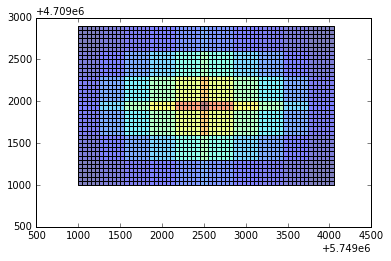

In [112]:
ax = bins.plot(column="fold")

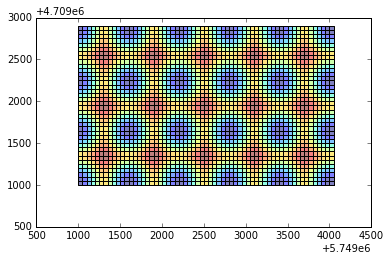

In [113]:
ax = bins.plot(column="min_offset")

<hr />

<div>
<img src="https://avatars1.githubusercontent.com/u/1692321?s=50"><p style="text-align:center">© Agile Geoscience 2016</p>
</div>